# Dogs vs. cats image classification: Inception V3

In [13]:
# Handle imports up-front
import os
import sys
import glob

# Silence logging messages from TensorFlow, except errors
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# Use a specific GPU
#os.environ['CUDA_VISIBLE_DEVICES']='1'

# PyPI imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import SGD
from keras import regularizers
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Figure out if we are running on Kaggle or not, if so
# add the location of utils.py to path so we can import
path_list=os.getcwd().split(os.sep)

if path_list[1] == 'kaggle':
    sys.path.append('/kaggle/usr/lib/image_classification_functions')

# Import custom helper functions from utils.py
from image_classification_functions import prep_data
from image_classification_functions import plot_single_training_run

# Silence logging messages from TensorFlow, except errors
tf.get_logger().setLevel('ERROR')

# Limit TensorFlow's CPU usage
tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(4)

## 1. Data preparation

### 1.1. Load the data paths

In [2]:
# Decompress and organize the images
training_data_path, testing_data_path=prep_data()

# Get lists of training dog and cat images
training_dogs=glob.glob(f'{training_data_path}/dogs/dog.*')
training_cats=glob.glob(f'{training_data_path}/cats/cat.*')

Running in Kaggle notebook
Checking data prep
Missing /kaggle/working/images/training/cats
Missing /kaggle/working/images/training/dogs
Missing /kaggle/working/images/testing/cats
Missing /kaggle/working/images/testing/dogs
Running data prep
Image archive should be at /kaggle/input/dogs-vs-cats/train.zip
Image extraction complete
Making training and testing datasets
Moving files to train & test, cat & dog subdirectories
Done


### 1.2. Create training and validation datasets

In [3]:
training_dataset, validation_dataset=tf.keras.utils.image_dataset_from_directory(
    training_data_path,
    validation_split=0.2,
    subset='both',
    seed=315,
    image_size=(256, int(256*(3/4))),
    batch_size=16
)

Found 17500 files belonging to 2 classes.
Using 14000 files for training.
Using 3500 files for validation.


### 1.3. Create testing dataset

In [4]:
testing_dataset=tf.keras.utils.image_dataset_from_directory(
    training_data_path,
    image_size=(256, int(256*(3/4)))
)

Found 17500 files belonging to 2 classes.


## 2. Model fine-tuning
### 2.1. Train output layers

In [5]:
%%time

# create the base pre-trained model
base_model=InceptionV3(weights='imagenet', include_top=False)

# Add some output layers
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.5)(x)
x=Dense(
    1024,
    activation='relu',
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
)(x)
x=Dense(
    256,
    activation='relu',
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
)(x)
x=Dense(
    128,
    activation='relu',
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
)(x)
x=Dense(
    64,
    activation='relu',
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
)(x)
predictions=Dense(1, activation='sigmoid')(x)

model=Model(inputs=base_model.input, outputs=predictions)

# Train only the output layers by freezing all convolutional InceptionV3 layers
for layer in base_model.layers:
   layer.trainable = False

# Compile the model to train on binary cross-entropy loss
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])

# Train the model on the new data for a few epochs
training_result=model.fit(
   training_dataset,
   validation_data=validation_dataset,
   epochs=10
)

print()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - binary_accuracy: 0.5264 - loss: 3.9613 - val_binary_accuracy: 0.5774 - val_loss: 0.8131
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - binary_accuracy: 0.5993 - loss: 0.7584 - val_binary_accuracy: 0.6269 - val_loss: 0.6808
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - binary_accuracy: 0.6111 - loss: 0.6879 - val_binary_accuracy: 0.6449 - val_loss: 0.6478
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - binary_accuracy: 0.6311 - loss: 0.6691 - val_binary_accuracy: 0.6140 - val_loss: 0.6648
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - binary_accuracy: 0.6344 - loss: 0.6588 - val_binary_accuracy: 0.6583 - val_loss: 0.6527
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - binary_accuracy: 0.6411 - loss: 0.6536 - val_binary_accuracy: 0.6406 - val_loss: 0.6553
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - binary_accuracy: 0.6388 - los

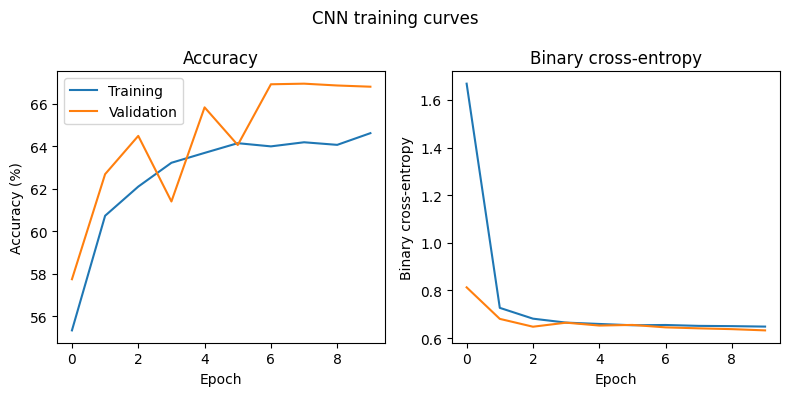

In [6]:
# Plot the results
plot_single_training_run(training_result).show()

### 2.2. Train inception layers

In [7]:
# Take a look at the model and decide how many layers to freeze andhow many to train
base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, None, None, 32) │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, None, None, 32) │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, None, 32) │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, None, None, 32) │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, None, None, 32) │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, None, 64) │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, None, None, 64) │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, None, None, 64) │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, None, None, 64) │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, None, None, 80) │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, None, None, 80) │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, None, None, 80) │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, None, None,     │        138,240 │ activation_3[0][0]     │
│                           │ 192)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, None, None,     │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │ 192)                   │                │                        │
├──────────────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [8]:
%%time

# Train the top 2 inception blocks, by freezing the first 249 layers
# and leaving the rest unfrozen
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# Recompile the model using SGD with a low learning rate
model.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# Train again
training_result=model.fit(
   training_dataset,
   validation_data=validation_dataset,
   epochs=10
)

print()

Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 60s 49ms/step - binary_accuracy: 0.5065 - loss: 0.7161 - val_binary_accuracy: 0.5051 - val_loss: 0.7110
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - binary_accuracy: 0.5068 - loss: 0.7100 - val_binary_accuracy: 0.5051 - val_loss: 0.7056
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - binary_accuracy: 0.5057 - loss: 0.7055 - val_binary_accuracy: 0.5100 - val_loss: 0.7007
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - binary_accuracy: 0.5238 - loss: 0.7011 - val_binary_accuracy: 0.5969 - val_loss: 0.6956
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - binary_accuracy: 0.5911 - loss: 0.6964 - val_binary_accuracy: 0.6491 - val_loss: 0.6887
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - binary_accuracy: 0.6303 - loss: 0.6896 - val_binary_accuracy: 0.6486 - val_loss: 0.6780
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - binary_accuracy: 0.6390 - loss: 0.6794 - val_binary_accuracy: 0.6537 - val_loss:

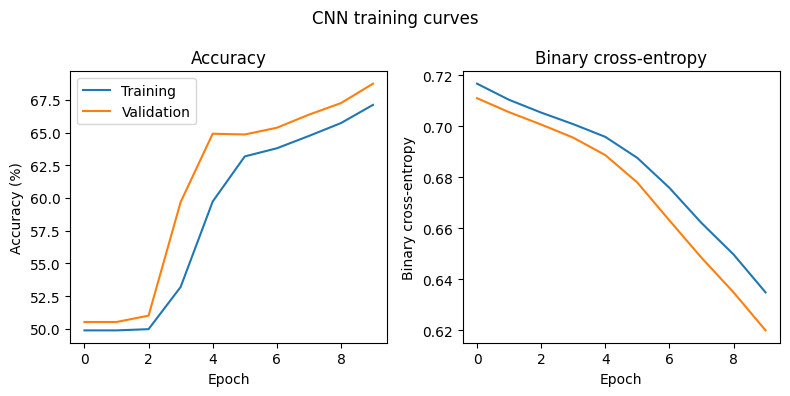

In [9]:
# Plot the results
plot_single_training_run(training_result).show()

## 3. Model evaluation

### 3.2. Make predictions

In [17]:
threshold=0.5
images=np.concatenate([x for x, y in validation_dataset], axis=0)
labels=np.concatenate([y for x, y in validation_dataset], axis=0)

predictions=training_result.model.predict(images)
predictions=[1 if p > threshold else 0 for p in predictions]
accuracy=accuracy_score(predictions, labels)*100

print(f'Test set accuracy: {accuracy:.1f}%')

110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
Test set accuracy: 68.7%


### 3.3. Model performance

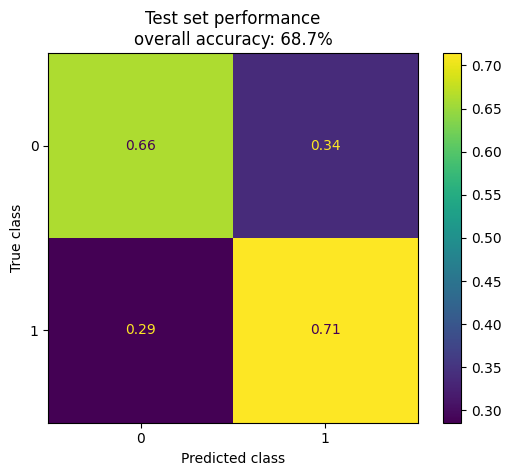

In [18]:
# Plot the confusion matrix
cm=confusion_matrix(labels, predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot()

plt.title(f'Test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()